<a href="https://colab.research.google.com/github/pleteneva/Detection-vehicle-registration-plate/blob/main/Detection_vehicle_registration_plate_(pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Установка необходимых библиотек

In [1]:
!pip install -q albumentations -U
!pip install -q pytorch_lightning

     |████████████████████████████████| 81kB 7.4MB/s 
     |████████████████████████████████| 37.6MB 136kB/s 
     |████████████████████████████████| 952kB 62.5MB/s 
     |████████████████████████████████| 829kB 15.7MB/s 
     |████████████████████████████████| 829kB 56.1MB/s 
     |████████████████████████████████| 276kB 56.2MB/s 
     |████████████████████████████████| 112kB 33.8MB/s 
     |████████████████████████████████| 1.3MB 51.4MB/s 
     |████████████████████████████████| 296kB 60.1MB/s 
     |████████████████████████████████| 143kB 56.9MB/s 


## Импорт библиотек

In [2]:
import pytorch_lightning as pl
import torch
import numpy as np
import random
import numpy
import os
import sys
import pandas as pd
import albumentations as A
from albumentations.pytorch import ToTensor, ToTensorV2
import torchvision.transforms as transforms 

%matplotlib inline
import random

import cv2
import torch
import torchvision
from matplotlib import pyplot as plt
from PIL import Image
from typing import Optional, List

print("Torch", torch.__version__)

USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("Use CUDA")

def set_figure_size(figsize=(10, 10), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

Torch 1.8.0+cu101
Use CUDA


In [3]:
!git clone https://github.com/pleteneva/Detection-vehicle-registration-plate.git tmp
!mv tmp/* ./.
!rm -rf tmp

Cloning into 'tmp'...
remote: Enumerating objects: 47, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 47 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (47/47), done.


In [4]:
from dataset_open_images import OpenImagesDataset
from visualization import visualize_from_dataset
from support_utils import freeze_seed
from train_loop import train_one_epoch

In [5]:
freeze_seed()

## Датасет

In [6]:
root = 'data/'
class_name = ['Vehicle registration plate']

In [7]:
img_transforms_train = transforms.Compose([
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(contrast=0.5),
        transforms.ColorJitter(saturation=0.5),
        transforms.ColorJitter(hue=0.5),
        transforms.RandomGrayscale(p=0.5),
        transforms.GaussianBlur(3, sigma=(0.1, 5.0))]),
    transforms.ToTensor(),
])

img_transforms_test = transforms.Compose([
    transforms.ToTensor(),
])

In [8]:
train_ds = OpenImagesDataset(root=root,
                             part='train', 
                             class_names = class_name,
                             transforms = img_transforms_train)
val_ds = OpenImagesDataset(root=root, 
                           part='validation', 
                           class_names = class_name,
                           transforms = img_transforms_test)
test_ds = OpenImagesDataset(root=root, 
                            part='test', 
                            class_names = class_name,
                            transforms = img_transforms_test)

print("\ntrain dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))
print("test dataset length:", len(test_ds))

installing boto3 and botocore for downloader by openimages ...

train dataset length: 5368
validation dataset length: 724
test dataset length: 2065


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


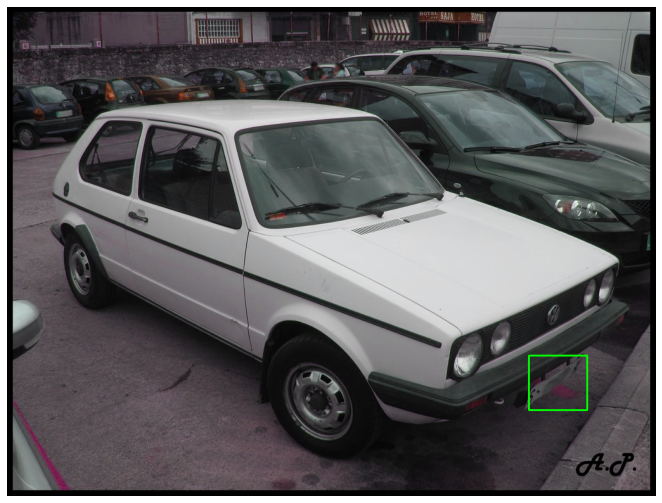

In [9]:
visualize_from_dataset(train_ds[10])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


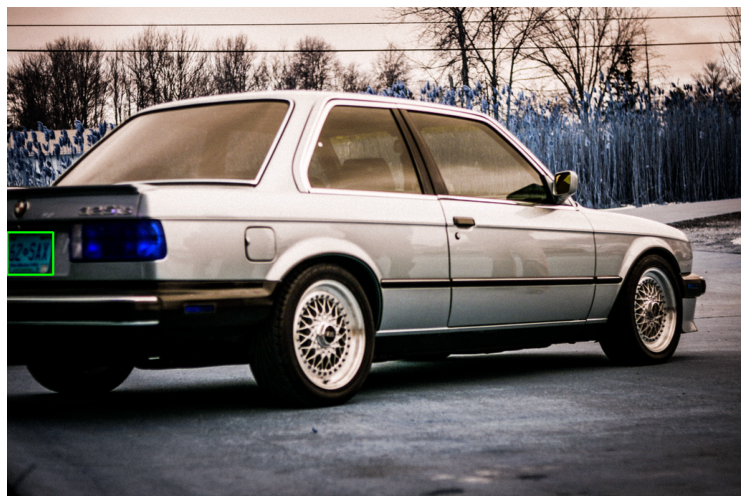

In [10]:
visualize_from_dataset(val_ds[10])

## Make dataloaders

In [11]:
def collate_fn(batch):
    return tuple(zip(*batch))


data_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=8, shuffle=True, 
    collate_fn=collate_fn, drop_last=True)

data_loader_val = torch.utils.data.DataLoader(
    val_ds, batch_size=8, shuffle=False, 
    collate_fn=collate_fn, drop_last=False)

data_loader_test = torch.utils.data.DataLoader(
    test_ds, batch_size=8, shuffle=False, 
    collate_fn=collate_fn, drop_last=False)

## Model

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import math
import sys
import time
import torch
from engine import evaluate

from coco_utils import get_coco_api_from_dataset
from coco_eval import CocoEvaluator
import utils

In [13]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, 
                                                             progress=True,
                                                             num_classes=91, 
                                                             pretrained_backbone=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [14]:
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [15]:
assert model.roi_heads.box_predictor.cls_score.in_features == 1024
assert model.roi_heads.box_predictor.cls_score.out_features == 2
assert model.roi_heads.box_predictor.bbox_pred.out_features == 8

In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

for param in model.parameters():
    param.requires_grad = False
    
for param in model.rpn.parameters():
    param.requires_grad = True
    
for param in model.roi_heads.parameters():
    param.requires_grad = True

params = [p for p in model.parameters() if p.requires_grad]

optimizer = torch.optim.SGD(params, 
                            lr=0.005,
                            momentum=0.9, 
                            weight_decay=0.0005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=30,
                                               gamma=0.1)

In [ ]:
num_epochs=100
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
    lr_scheduler.step()
    evaluate(model, data_loader_val, device=device)
    torch.save(model.state_dict(), 'model_state_dict_last.pth')

Epoch: [0]  [  0/671]  eta: 0:14:38  lr: 0.000012  loss: 1.3837 (1.3837)  loss_classifier: 0.8335 (0.8335)  loss_box_reg: 0.0159 (0.0159)  loss_objectness: 0.4853 (0.4853)  loss_rpn_box_reg: 0.0491 (0.0491)  time: 1.3098  data: 0.4582
Epoch: [0]  [ 50/671]  eta: 0:09:09  lr: 0.000385  loss: 0.3656 (0.6755)  loss_classifier: 0.0470 (0.2475)  loss_box_reg: 0.0217 (0.0279)  loss_objectness: 0.2217 (0.3494)  loss_rpn_box_reg: 0.0211 (0.0506)  time: 0.8700  data: 0.3432
Epoch: [0]  [100/671]  eta: 0:08:17  lr: 0.000758  loss: 0.1950 (0.4803)  loss_classifier: 0.0610 (0.1578)  loss_box_reg: 0.0416 (0.0356)  loss_objectness: 0.0669 (0.2402)  loss_rpn_box_reg: 0.0191 (0.0466)  time: 0.8773  data: 0.3343
Epoch: [0]  [150/671]  eta: 0:07:30  lr: 0.001131  loss: 0.1831 (0.3994)  loss_classifier: 0.0607 (0.1273)  loss_box_reg: 0.0592 (0.0441)  loss_objectness: 0.0412 (0.1833)  loss_rpn_box_reg: 0.0128 (0.0448)  time: 0.8478  data: 0.3366
Epoch: [0]  [200/671]  eta: 0:06:46  lr: 0.001503  loss: 0.1